Nico et Aurel

# Twitter
Dans ce notebook, nous présentons une analyse des tweets des différents députés français afin de comprendre leur dynamique et leur structure.

## Chargement des librairies
Les librairies que nous utiliserons dans ce notebook sont :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

On importe maintenant nos jeux de données

In [4]:
d1 = pd.read_excel("Data/Tweet/data_tweet.xlsx")
d2 = pd.read_excel("Data/Tweet/data_retweet.xlsx")
df2 = pd.read_excel("Data/Tweet/depute.xlsx")

Puis on va concatener nos dataframe de tweets et de retweets en un seul jeu de données. Ici il s'agit d'une simple supperposition des deux jeux de données.

In [5]:
df1 = pd.concat([d1, d2], axis=0)

# Pour éviter qu'à chaque fois on fasse des df.head(), on crée une fonction pour aller plus vite:
def h(d):
    return d.head()
h(df1)

,name,id,retweet,date_tweet,date_tweet_original,text
0,@_didierparis,1573960903082577920,no,Sun Sep 25 09:01:36 +0000 2022,NaN,Marie-Louise Fort a porté un engagement politi...
1,@_didierparis,1248014208781790976,no,Wed Apr 08 22:25:49 +0000 2020,NaN,Face au #Covid19\nLe @gouvernementFR facilite ...
2,@_didierparis,1248991409954225920,no,Sat Apr 11 15:08:51 +0000 2020,NaN,"Ensemble, nous formons la #FranceUnie contre l..."
3,@_didierparis,1248010336503868928,no,Wed Apr 08 22:10:25 +0000 2020,NaN,Face au #Covid19\nAfin de faciliter le verseme...
4,@_didierparis,1250310724410150912,no,Wed Apr 15 06:31:21 +0000 2020,NaN,🇫🇷 🏛 #DirectAN #QAG 🏛🇫🇷\n« Il appartient au @g...


Maintenant ce qu'on constate c'est que dans les identifiants utilisateurs (les `@`) des députés il y a des majuscules. On va tout mettre en miniscule pour faciliter notre analyse et éviter que la personne soit considérée comme autre entité du fait d'une majuscule dans son `@`

In [5]:
def col_low(var):
    if pd.isna(var):
        return var
    else:
        return var.lower()

df1['name'] = df1['name'].apply(col_low)
df2['Twitter'] = df2['Twitter'].apply(col_low)

A présent, nous allons ajouter les noms et les parties politiques des députés dans le jeu de données df1.

Pour ce faire, on va récupérer les noms et les parti politiques associété dans df2, et les merge à df1 par rapport à leur id utilisatuers

In [6]:
df2_cop = df2[['Twitter', 'Nom', 'Parti']] # On récupère les infos dont on a besoin
df = pd.merge(df1, df2_cop, how='left', left_on='name', right_on='Twitter') # ET on merge les deux pour avoir un df final
h(df)
df.to_csv("df.csv", index = False, encoding='utf8')

### Gestion des valeurs manquantes
Ici on constate qu'il y a 4.7% de valeurs manquantes dans les partis politiques. Pour simplifier notre exploration, elles seront supprimées

In [7]:
df.isna().mean() * 100

name                    0.000000
id                      0.000000
retweet                 0.000000
date_tweet              0.000000
date_tweet_original    52.146428
text                    0.001904
Twitter                 0.000000
Nom                     0.000000
Parti                   4.747725
dtype: float64

In [8]:
df.dropna(subset=['Parti'], inplace=True)
df.drop(columns=['Twitter'], inplace=True) # On supprimer cette colonne car on en a plus besoin

Ensuite on va créer une variable 'month' qui va contenir nos dates au format 'mois-année' (type : string). Cela permettra par la suite de grouper les obervations par mois

In [9]:
df['month'] = pd.to_datetime(df['date_tweet']).dt.strftime('%b-%Y')
h(df)

C:\Users\aurel\AppData\Local\Temp\ipykernel_33356\2450480701.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['date_tweet']).dt.strftime('%b-%Y')


,name,id,retweet,date_tweet,date_tweet_original,text,Nom,Parti,month
0,@_didierparis,1573960903082577920,no,Sun Sep 25 09:01:36 +0000 2022,NaN,Marie-Louise Fort a porté un engagement politi...,m. didier paris,Renaissance,Sep-2022
1,@_didierparis,1248014208781790976,no,Wed Apr 08 22:25:49 +0000 2020,NaN,Face au #Covid19\nLe @gouvernementFR facilite ...,m. didier paris,Renaissance,Apr-2020
2,@_didierparis,1248991409954225920,no,Sat Apr 11 15:08:51 +0000 2020,NaN,"Ensemble, nous formons la #FranceUnie contre l...",m. didier paris,Renaissance,Apr-2020
3,@_didierparis,1248010336503868928,no,Wed Apr 08 22:10:25 +0000 2020,NaN,Face au #Covid19\nAfin de faciliter le verseme...,m. didier paris,Renaissance,Apr-2020
4,@_didierparis,1250310724410150912,no,Wed Apr 15 06:31:21 +0000 2020,NaN,🇫🇷 🏛 #DirectAN #QAG 🏛🇫🇷\n« Il appartient au @g...,m. didier paris,Renaissance,Apr-2020


## **Nombre de tweets par partis politiques par mois**

Pour ce faire nous allons présenter 2 graphiques :

- Un graph pour les tweets
- Un graph pour les retweets

Dans un premier temps on va grouper les twweets (ou retweets) par mois et par parti politiques pour avoir leur nombre

In [10]:
retw = df[df['retweet']=='yes'].groupby(['month', 'Parti']).size().reset_index(name='retweets') # retweets
tw = df[df['retweet']=='no'].groupby(['month', 'Parti']).size().reset_index(name='tweets') # tweets

On obtient deux dataframes dans lesquels on a la date, le parti et nombre de tweets/retweets qu'il a posté

In [11]:
h(retw)

,month,Parti,retweets
0,Apr-2011,Démocrate (MoDem et Indépendants),1
1,Apr-2011,Renaissance,5
2,Apr-2012,Démocrate (MoDem et Indépendants),2
3,Apr-2012,La France insoumise - Nouvelle Union Populaire...,16
4,Apr-2012,Les Républicains,78


In [12]:
h(tw)

,month,Parti,tweets
0,Apr-2010,Les Républicains,1
1,Apr-2010,Renaissance,6
2,Apr-2011,Démocrate (MoDem et Indépendants),11
3,Apr-2011,Les Républicains,12
4,Apr-2011,Renaissance,18


#### **Les retweets**

D'abord, nous pivotons cette table afin d'avoir les partis en colonnes (chaque parti devient une variable) et avoir pour chaque mois, en ligne, le nombre de tweets.

Ensuite on convertis nos mois en date et trie notre dataframe en fonction des mois (pour qu'il aille du plus ancien eau plus récent)

Enfin pour avoir les noms des mois sur nos axes x, on change le formattage de nos date pour une format : 'mois-année'

In [13]:
retw = retw.pivot(index='month', columns='Parti', values='retweets')
retw.index = pd.to_datetime(retw.index, format='%b-%Y')
retw = retw.sort_index()
retw.index = retw.index.strftime('%b-%Y')
h(retw)

Parti,Démocrate (MoDem et Indépendants),Gauche démocrate et républicaine - NUPES,Horizons et apparentés,La France insoumise - Nouvelle Union Populaire écologique et sociale,Les Républicains,"Libertés, Indépendants, Outre-mer et Territoires",Non inscrit,Rassemblement National,Renaissance,Socialistes et apparentés (membre de l’intergroupe NUPES),Écologiste - NUPES
month,,,,,,,,,,,
Mar-2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Jul-2010,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
Sep-2010,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
Oct-2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
Nov-2010,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,9.0,NaN,NaN


Et on représente maintenant le nombre de retweets posté par parti politique au fil du temps

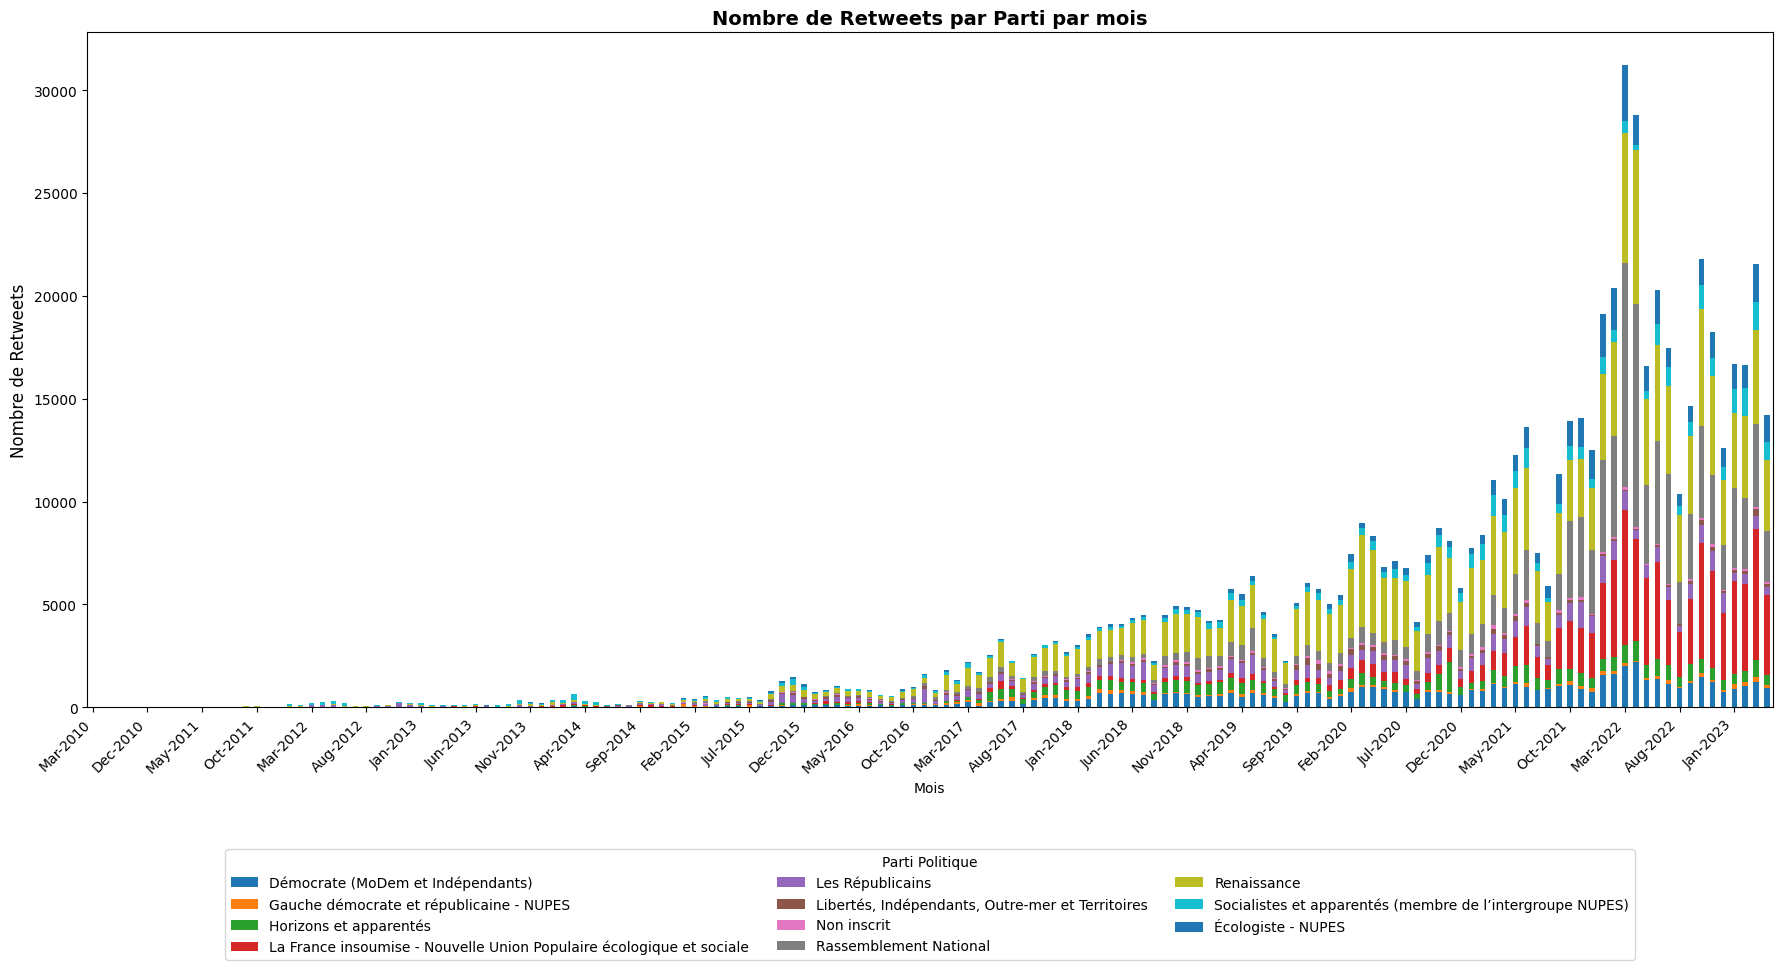

In [14]:
retw.plot(kind='bar', stacked=True, figsize=(18, 10))
sns.reset_orig()
plt.xticks(ticks=range(0, len(retw.index), 5), labels=retw.index[::5], rotation=45, ha='right') # ici on veut afficher les mois selon un intervalle de 5 sur l'axe des x (temps)
plt.xlabel('Mois', fontsize=10)
plt.ylabel('Nombre de Retweets', fontsize=12)
plt.title('Nombre de Retweets par Parti par mois', fontsize=14, fontweight='bold')
plt.legend(title='Parti Politique', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

#### **Les tweets**

De même que pour les retweets on représente les tweets

In [15]:
tw = tw.pivot(index='month', columns='Parti', values='tweets')
tw.index = pd.to_datetime(tw.index, format='%b-%Y')
tw = tw.sort_index()
tw.index = tw.index.strftime('%b-%Y')
h(tw)

Parti,Démocrate (MoDem et Indépendants),Gauche démocrate et républicaine - NUPES,Horizons et apparentés,La France insoumise - Nouvelle Union Populaire écologique et sociale,Les Républicains,"Libertés, Indépendants, Outre-mer et Territoires",Non inscrit,Rassemblement National,Renaissance,Socialistes et apparentés (membre de l’intergroupe NUPES),Écologiste - NUPES
month,,,,,,,,,,,
Dec-2009,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN
Jan-2010,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN
Feb-2010,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,NaN
Mar-2010,13.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,4.0,9.0,NaN
Apr-2010,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,6.0,NaN,NaN


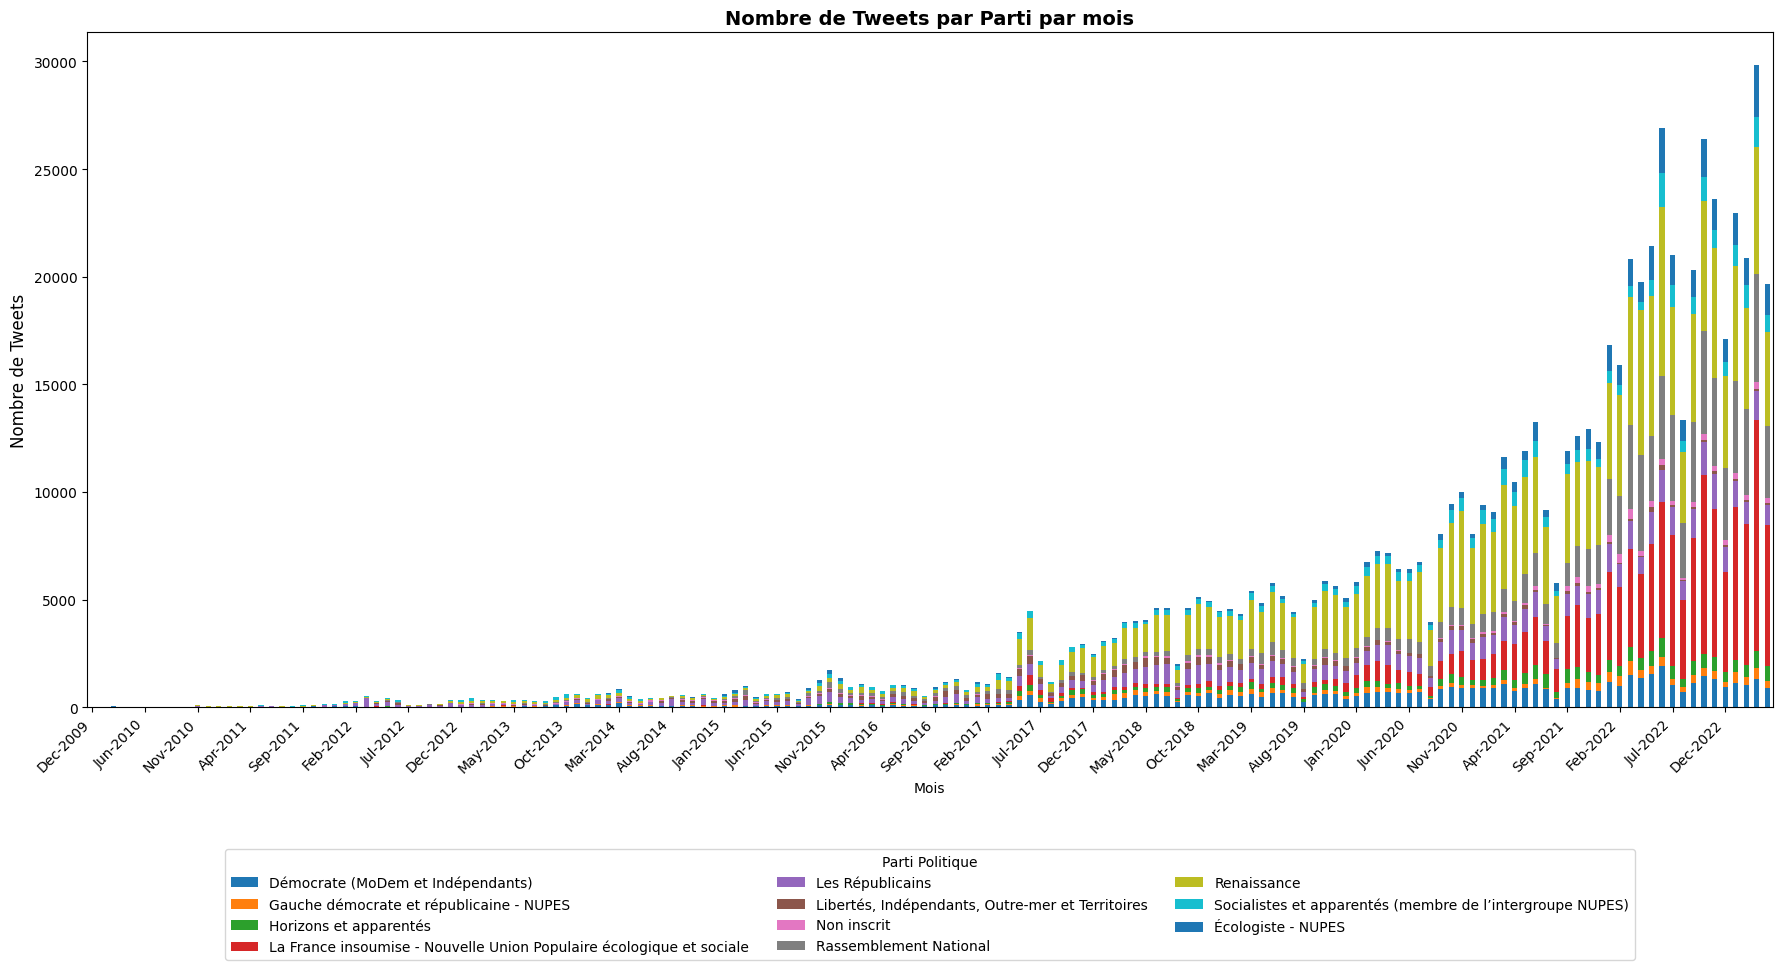

In [16]:
tw.plot(kind='bar', stacked=True, figsize=(18, 10))
sns.reset_orig()
plt.xticks(ticks=range(0, len(tw.index), 5), labels=tw.index[::5], rotation=45, ha='right')
plt.xlabel('Mois', fontsize=10)
plt.ylabel('Nombre de Tweets', fontsize=12)
plt.title('Nombre de Tweets par Parti par mois', fontsize=14, fontweight='bold')
plt.legend(title='Parti Politique', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

## **Evolution du nombre de tweets et retweets** (additionnel)

Ici nous présentons une bref analyse de l'impact du temps sur le nombre de tweets et de retweets par mois

D'emblée, on recupère le nombre de tweet-retweets posté par chaque parti durant chaque mois, qu'on représente ensuite à l'aide d'une courbe d'évolution

In [17]:
b = df.groupby('month')['Parti'].size()
b = b.reset_index()
b.columns = ['month', 'n']
b['month'] = pd.to_datetime(b['month'])
b = b.sort_values(by='month')
b['month'] = b['month'].dt.strftime('%b-%Y')

C:\Users\aurel\AppData\Local\Temp\ipykernel_33356\2190219378.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  b['month'] = pd.to_datetime(b['month'])


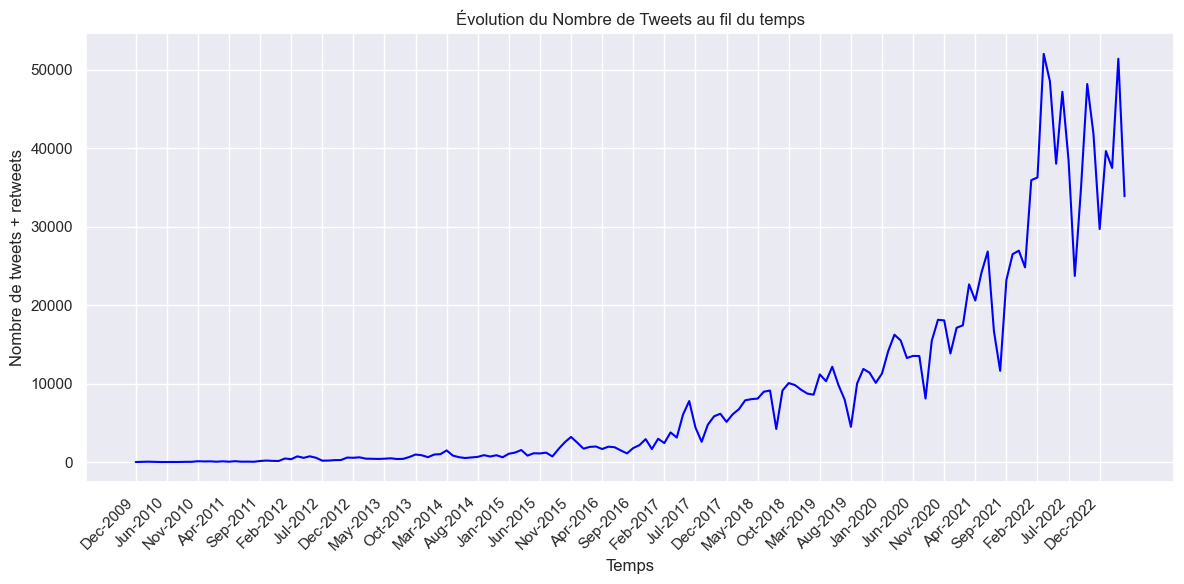

In [18]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(b['month'], b['n'], linestyle='-', color='blue')
plt.title("Évolution du Nombre de Tweets au fil du temps")
plt.xticks(ticks=range(0, len(b.index), 5), labels=b['month'][::5], rotation=45, ha='right')
plt.xlabel("Temps")
plt.ylabel("Nombre de tweets + retweets")
plt.grid()
plt.tight_layout()
plt.grid()
plt.show()

La courbe montre une nette augmentation du nombre de tweets et retweets au fil du temps, avec un fort pic après 2020.

Jusqu'en nov 2015, l'activité sur Twitter reste faible, avec des variations mineures. À partir de 2018, on observe une tendance à la hausse plus marquée. Cela montre un intérêt croissant pour le réseau social. La montée rapide après 2020 pourrait être liée à un événement majeur (élection, débats parlementaires...) ou à une tendance sociale accrue vers l'utilisation de Twitter (crises sociales, rentrées parlementaires...).

Enfin, à partir de 2018, on observe un certain rythme cyclique dans l'évolution de cette courbe.

Pour modéliser la relation entre le temps et le nombre de tweets des partis politiques on utilise une simple linear reg:

In [19]:
b['t'] = np.arange(1, len(b) + 1) # On crée une variable qui va representer le temps
h(b)

,month,n,t
27,Dec-2009,5,1
55,Jan-2010,28,2
41,Feb-2010,49,3
95,Mar-2010,29,4
0,Apr-2010,7,5


La forme de cette courbe suggère une **loi de puissance** du type `n = t^a`, où le nombre de tweets `n` pourrait être proportionnel à une puissance du temps `t`. En observant la croissance des tweets des députés français, une loi de puissance permettrait de capturer la dynamique sous-jacente de leur activité en ligne au fil du temps.

Pour modéliser cette relation, nous ferons une régression sur les données transformées en logarithme, ce qui simplifie l’ajustement et facilite l'estimation de l'exposant `a`.

En prenant le logarithme des deux côtés de l'équation `n = t^a`, nous obtenons une forme linéaire :

> log(n) = constante + a * log(t)

Le paramètre `a` représente le rythme de croissance et, en interprétant sa valeur, nous pourrons mieux comprendre l'évolution de l'activité des députés sur Twitter.

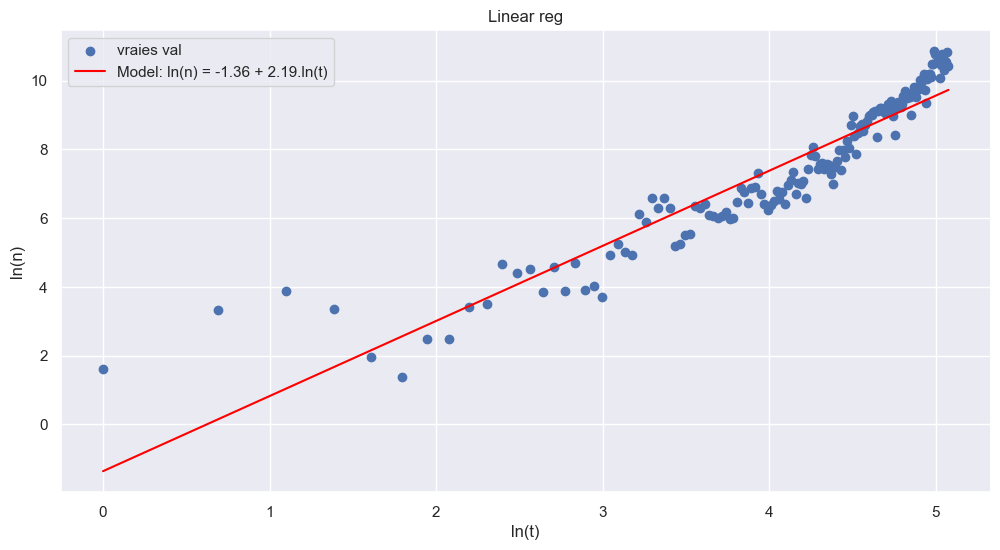


Linear Reg ln(n) = constante + alpha.ln(t)
    constante = -1.36 
    alpha = 2.19



In [20]:
from sklearn.linear_model import LinearRegression

b['log_n'] = np.log(b['n']) # On convertis le nombre de tweets en log pour réduire l'amplitude des variations
b['log_t'] = np.log(b['t'])
# Et on effectue notre régression :
model = LinearRegression()
model.fit(b[['log_t']], b['log_n'])

alpha = model.coef_[0]
constante = model.intercept_

# On peut plot notre régression
b['log_n_pred'] = model.predict(b[['log_t']])

plt.figure(figsize=(12, 6))
plt.scatter(b['log_t'], b['log_n'], label='vraies val')
plt.plot(b['log_t'], b['log_n_pred'], color='red', label=f'Model: ln(n) = {constante:.2f} + {alpha:.2f}.ln(t)')
plt.xlabel('ln(t)')
plt.ylabel('ln(n)')
plt.legend()
plt.title('Linear reg')
plt.grid(color='white')
plt.show()

print(f"""
==========================================     
Linear Reg ln(n) = constante + alpha.ln(t)
==========================================
    constante = {constante:.2f} \n    alpha = {alpha:.2f}
""")

**Interpretation** : Chaque augmentation de 1 % du temps (en log) entraîne une augmentation de 2.19 % du nombre de tweets.

Cette relation suggère une croissance rapide, presque exponentielle, du nombre de tweets des députés au fil du temps

## **Les disparités dans les tweets au sein des partis politiques**

Dans cette partie nous allons analyser les diparités qu'on peut trouver au sein des tweets des différents parties politiques. Pour cela nous présenterons 4 graphiques clés :

- La moyenne de tweet pour un députés au sein d'un parti

- La dispersion des tweets par partis politiques

- L'intervalle de temps moyen entre chaque tweet au sein d'un parti

- La distribution de la part des retweets dans les posts (tweets + retweets) par partis politiques

Dans un premier temps on calcule les éléments qui vont nous permettre de réaliser cett tâche : la moyenne des tweets par député, la dispersion des tweets par parti, l'intervalle de temps moyen entre chaque tweet et le nombre de tweet/retweet par parti 

In [21]:
# Moyenne de tweets par député
tweets_per_depute = df.groupby('Parti').size() / df.groupby('Parti')['Nom'].nunique()

# Dispersion des tweets (nombre de tweets par partis)
tweets_dispersion = df.groupby('Parti').size().std()

# Intervalle de temps entre les tweets
df['date_tweet'] = pd.to_datetime(df['date_tweet']) # On convertis la colonne des date au format datetime
df = df.sort_values(by='date_tweet') # On trie par ordre chronologique
df['time_diff'] = df.groupby('Parti')['date_tweet'].diff().dt.seconds # On calcule la différence en secondes entre chaque tweet et le tweet précédent
time_interval = df.groupby('Parti')['time_diff'].mean() # Et enfin on fais la moyenne de ces differences

# Nombre de tweets et retweets
tweets_count = df[df['retweet'] == 'yes'].groupby('Parti').size()
retweets_count = df[df['retweet'] == 'no'].groupby('Parti').size()
rapport = retweets_count/(tweets_count + retweets_count) # on calcul ensuite la part des retweets dans le global (tweets + retweets)
rapport = rapport.sort_values(ascending=False)
h(rapport) # 5 plus grandes de reweets dans les posts

C:\Users\aurel\AppData\Local\Temp\ipykernel_33356\3906370631.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_tweet'] = pd.to_datetime(df['date_tweet']) # On convertis la colonne des date au format datetime


Parti
Gauche démocrate et républicaine - NUPES                                0.654285
Non inscrit                                                             0.615071
Libertés, Indépendants, Outre-mer et Territoires                        0.610099
Les Républicains                                                        0.591730
La France insoumise - Nouvelle Union Populaire écologique et sociale    0.569040
dtype: float64

Passons maintenant à la représentation graphique des éléments calculés.

D'abord pour légender notre graphique nous aurons besoin des noms des differents partis politiques :

In [22]:
partis = sorted(df['Parti'].unique())
for p in partis:
    print(p)

Démocrate (MoDem et Indépendants)
Gauche démocrate et républicaine - NUPES
Horizons et apparentés
La France insoumise - Nouvelle Union Populaire écologique et sociale
Les Républicains
Libertés, Indépendants, Outre-mer et Territoires
Non inscrit
Rassemblement National
Renaissance
Socialistes et apparentés (membre de l’intergroupe NUPES)
Écologiste - NUPES


C:\Users\aurel\AppData\Local\Temp\ipykernel_33356\2339141941.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tweets_per_depute.index, y=tweets_per_depute.values, ax=axs[0, 0], palette=parti_colors)
C:\Users\aurel\AppData\Local\Temp\ipykernel_33356\2339141941.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_interval.index, y=time_interval.values, ax=axs[1, 0], palette=parti_colors)
C:\Users\aurel\AppData\Local\Temp\ipykernel_33356\2339141941.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rapport.index, y=rapport.valu

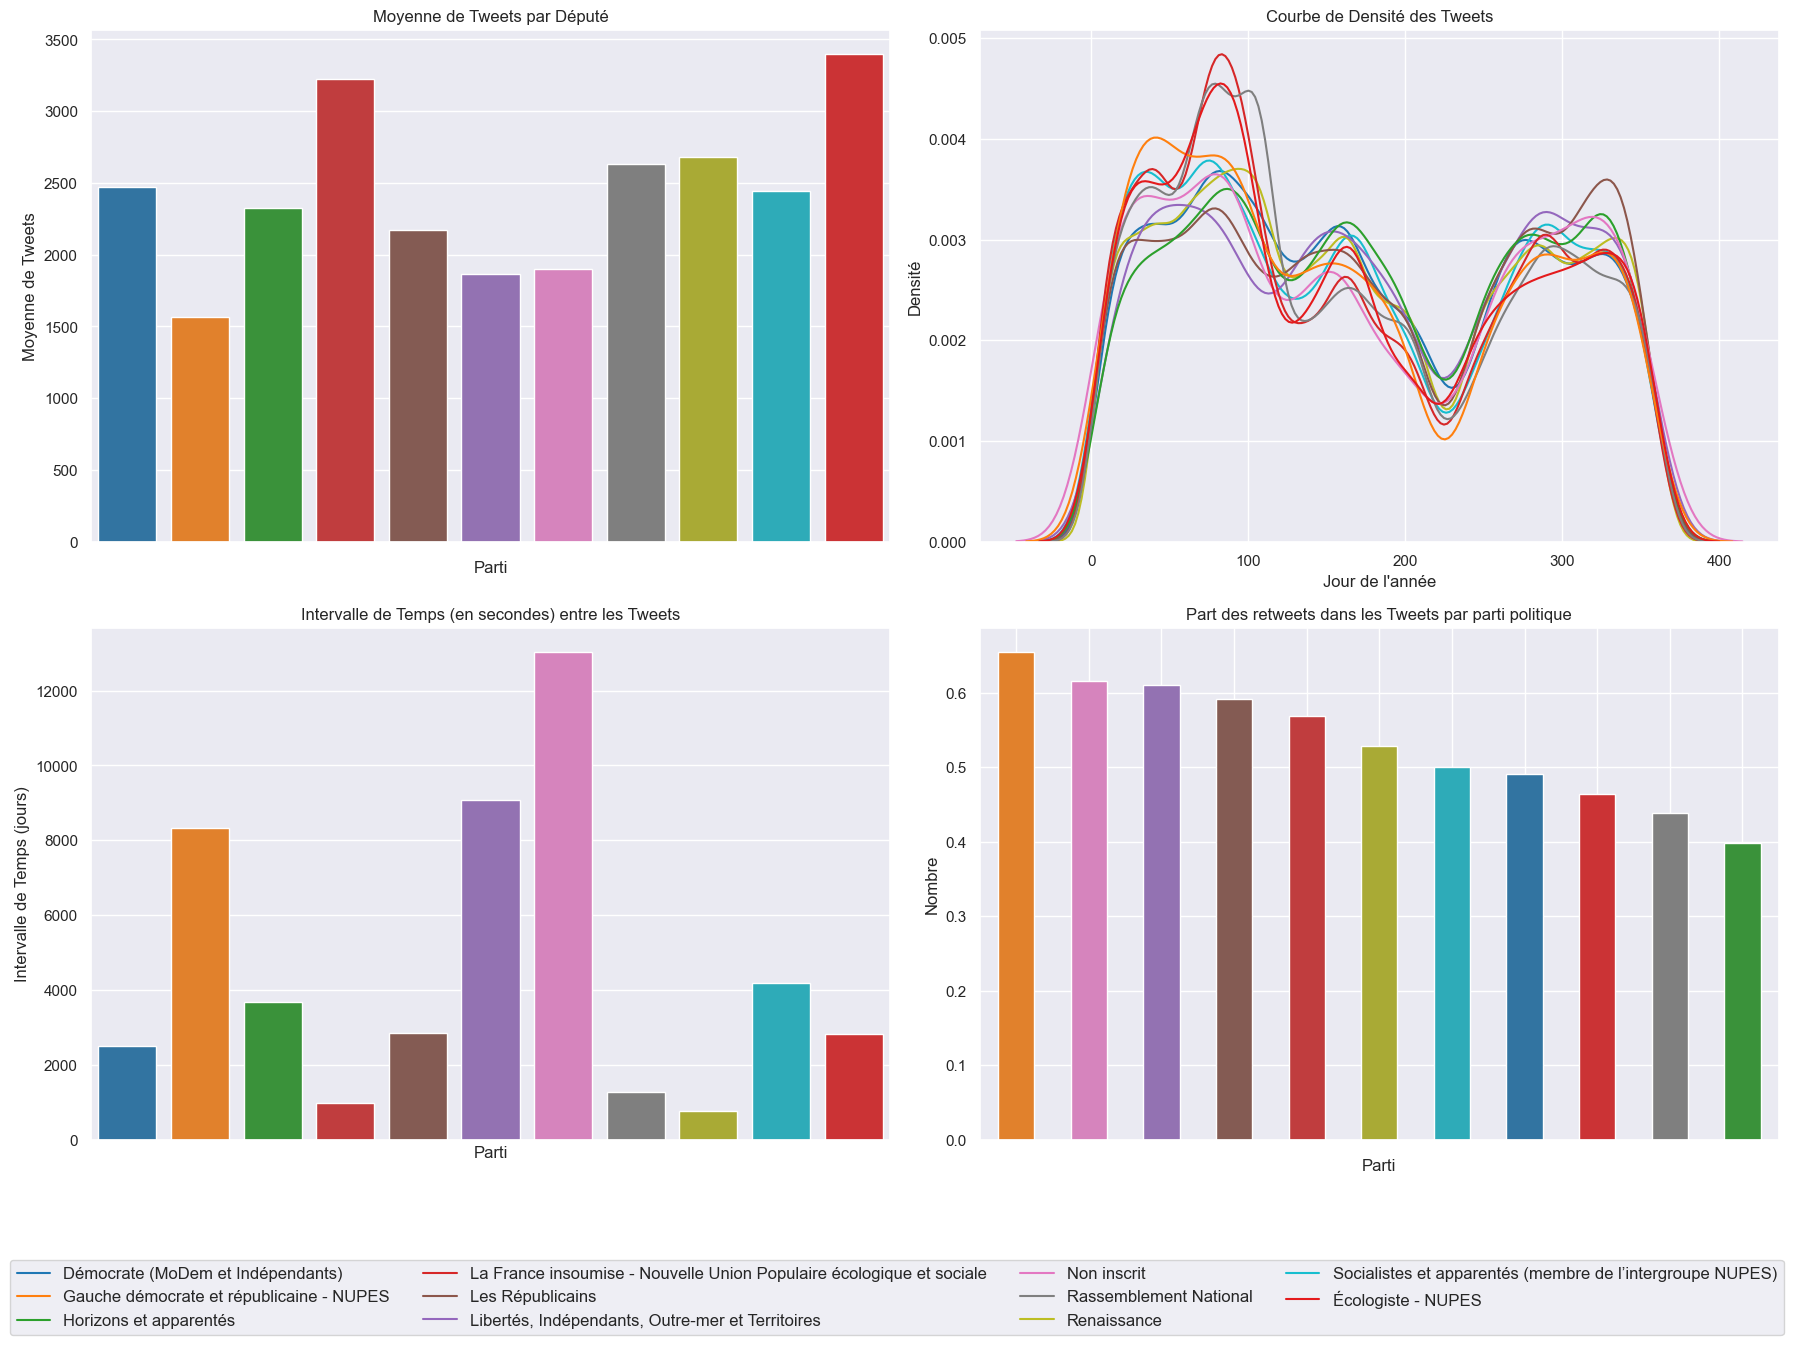

In [23]:
parti_colors = {
    'Démocrate (MoDem et Indépendants)': '#1f77b4',
    'Gauche démocrate et républicaine - NUPES': '#ff7f0e',
    'Horizons et apparentés': '#2ca02c',
    'La France insoumise - Nouvelle Union Populaire écologique et sociale': '#d62728',
    'Libertés, Indépendants, Outre-mer et Territoires': '#9467bd',
    'Les Républicains': '#8c564b',
    'Non inscrit': '#e377c2',
    'Rassemblement National': '#7f7f7f',
    'Renaissance': '#bcbd22',
    'Socialistes et apparentés (membre de l’intergroupe NUPES)': '#17becf',
    'Écologiste - NUPES': '#e41a1c'
}

# Création des sous-graphiques
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Moyenne de tweets par député
sns.barplot(x=tweets_per_depute.index, y=tweets_per_depute.values, ax=axs[0, 0], palette=parti_colors)
axs[0, 0].set_title('Moyenne de Tweets par Député')
axs[0, 0].set_xticklabels([])
axs[0, 0].set_xlabel('Parti')
axs[0, 0].set_ylabel('Moyenne de Tweets')

# Courbe de densité des tweets
for parti in df['Parti'].unique():
    sns.kdeplot(df[df['Parti'] == parti]['date_tweet'].dt.dayofyear, ax=axs[0, 1], label=parti, color=parti_colors.get(parti))
axs[0, 1].set_title('Courbe de Densité des Tweets')
axs[0, 1].set_xlabel('Jour de l\'année')
axs[0, 1].set_ylabel('Densité')
axs[0, 1].grid(True)

# Intervalle de temps entre les tweets
sns.barplot(x=time_interval.index, y=time_interval.values, ax=axs[1, 0], palette=parti_colors)
axs[1, 0].set_title('Intervalle de Temps (en secondes) entre les Tweets')
axs[1, 0].set_xlabel('Parti')
axs[1, 0].set_xticks([])
axs[1, 0].set_ylabel('Intervalle de Temps (jours)')

# Rapport entre le nombre de tweets et retweets
sns.barplot(x=rapport.index, y=rapport.values, ax=axs[1, 1], palette=parti_colors, width=0.5)
axs[1, 1].set_title('Part des retweets dans les Tweets par parti politique')
axs[1, 1].set_xlabel('Parti')
axs[1, 1].set_ylabel('Nombre')
axs[1, 1].set_xticklabels([])
axs[1, 1].grid(True)

# Trier les handles et labels dans l'ordre alphabétique
handles, labels = axs[0, 1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_handles_labels)
fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, markerscale=2, fontsize='medium')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.tight_layout()
plt.show()

## **Analyse du champ lexical des partis politiques**

Ici, nous allons d'abord importer les données fusionnées (tweets et retweets)

In [6]:
df = pd.read_csv("df.csv")
h(df)

C:\Users\aurel\AppData\Local\Temp\ipykernel_26676\3174425095.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df.csv")


,name,id,retweet,date_tweet,date_tweet_original,text,Twitter,Nom,Parti
0,@_didierparis,1573960903082577920,no,Sun Sep 25 09:01:36 +0000 2022,NaN,Marie-Louise Fort a porté un engagement politi...,@_didierparis,m. didier paris,Renaissance
1,@_didierparis,1248014208781790976,no,Wed Apr 08 22:25:49 +0000 2020,NaN,Face au #Covid19\nLe @gouvernementFR facilite ...,@_didierparis,m. didier paris,Renaissance
2,@_didierparis,1248991409954225920,no,Sat Apr 11 15:08:51 +0000 2020,NaN,"Ensemble, nous formons la #FranceUnie contre l...",@_didierparis,m. didier paris,Renaissance
3,@_didierparis,1248010336503868928,no,Wed Apr 08 22:10:25 +0000 2020,NaN,Face au #Covid19\nAfin de faciliter le verseme...,@_didierparis,m. didier paris,Renaissance
4,@_didierparis,1250310724410150912,no,Wed Apr 15 06:31:21 +0000 2020,NaN,🇫🇷 🏛 #DirectAN #QAG 🏛🇫🇷\n« Il appartient au @g...,@_didierparis,m. didier paris,Renaissance


On commence d'abord par définir une liste de mots vides en français pour les filtrer. Ensuite, nous allons créer une fonction de prétraitement preprocess_text qui nettoiera le texte en supprimant les URLs, mentions, caractères spéciaux, mots vides et mots trop courts. Nous appliquerons cette fonction à chaque tweet. Par la suite, nous regrouperons les tweets par parti politique pour compter les mots les plus fréquents dans chaque groupe à l'aide de Counter.

In [7]:
alternative_stop_words = {
    "l'", "le", "la", "les", "un", "une", "des", "et", "ou", "de", "du", "d'", "dans", "en", "par", 
    "pour", "sur", "avec", "sans", "ce", "cette", "ces", "je", "tu", "il", "elle", "nous", 
    "vous", "ils", "elles", "se", "s'", "mon", "ton", "son", "ma", "ta", "sa", "mes", "tes", 
    "ses", "notre", "votre", "leur", "leurs", "y", "a", "être", "avoir", "faire", "plus", 
    "moins", "tous", "tout", "toute", "toutes", "comme", "mais", "ou", "donc", "or", "ni", 
    "car", "bien", "aussi", "là", "autre", "autres", "avant", "après", "aujourd'hui", 
    "hier", "demain", "très", "peu", "encore", "déjà", "seulement", 
    "non", "oui", "on", "ça", "c'", "qui", "que", "quoi", "quand", "où", "comment", "pourquoi","au","est","pas","aux",
    "ne","cest","nos","sont","ont","jai","si","nest","fait"
}

In [8]:
def preprocess_text(text):
    if not isinstance(text, str):  # Vérifie que le texte est une chaîne
        text = ""  # Remplace les valeurs non-textuelles ou NaN par une chaîne vide
    text = text.lower()  # Conversion en minuscules
    text = re.sub(r'http\S+|@\S+|[^a-z\s]', '', text)  # Suppression des URL, mentions, caractères spéciaux
    words = [word for word in text.split() if word not in alternative_stop_words and len(word) > 1]
    return words

# Applique la fonction de prétraitement sur chaque tweet de manière sécurisée
df['processed_text'] = df['text'].apply(preprocess_text)

# Regroupement par parti et comptage des mots
party_lexical_counts = {
    party: Counter([word for tweet_words in group['processed_text'] for word in tweet_words]).most_common(15)
    for party, group in df.groupby('Parti')
}

Enfin, nous générerons un nuage de mots (WordCloud) pour chaque parti, visualisant ainsi les mots les plus représentatifs de chaque parti politique et voila les résultats qu'on obtient :


Top mots pour le parti Démocrate (MoDem et Indépendants):
france          7540           
merci           7187           
contre          5376           
ans             5362           
directan        5036           
loi             4892           
aujourdhui      4882           
franais         4189           
matin           4073           
trs             4014           
ministre        3981           
projet          3960           
travail         3958           
prsident        3920           
depuis          3830           

Top mots pour le parti Gauche démocrate et républicaine - NUPES:
directan        2738           
contre          1694           
france          1682           
macron          1440           
gouvernement    1382           
retraites       1280           
loi             1278           
pcf             1159           
ans             1065           
rforme          1026           
franais         1003           
travail         1001           
ministre   

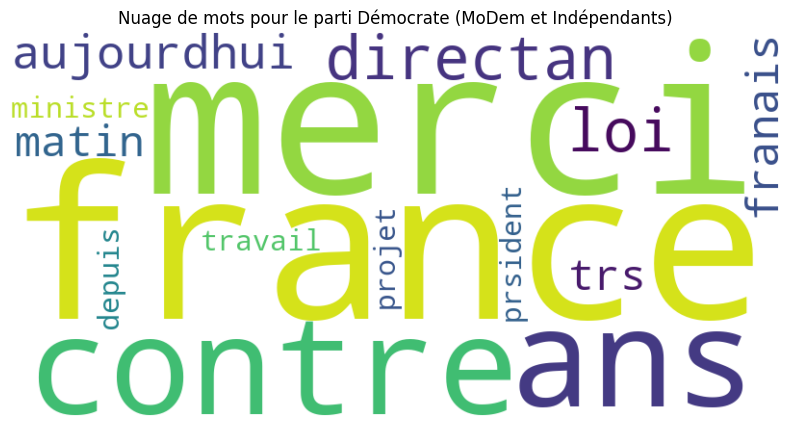

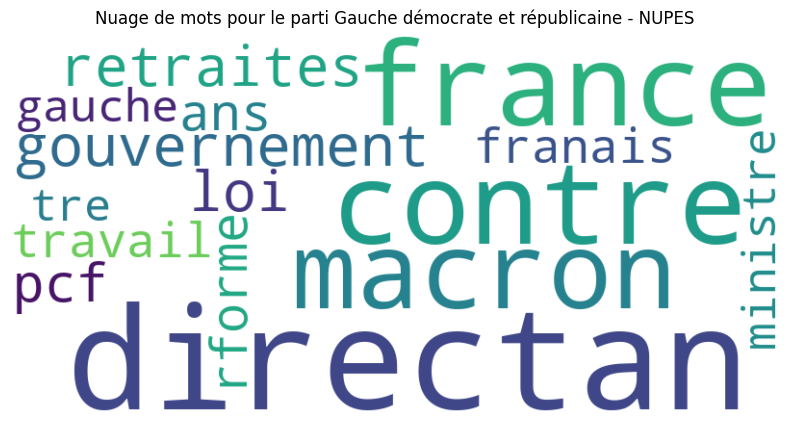

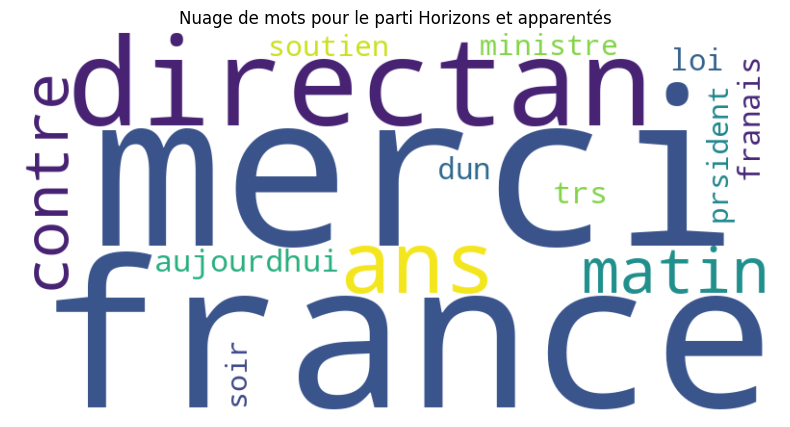

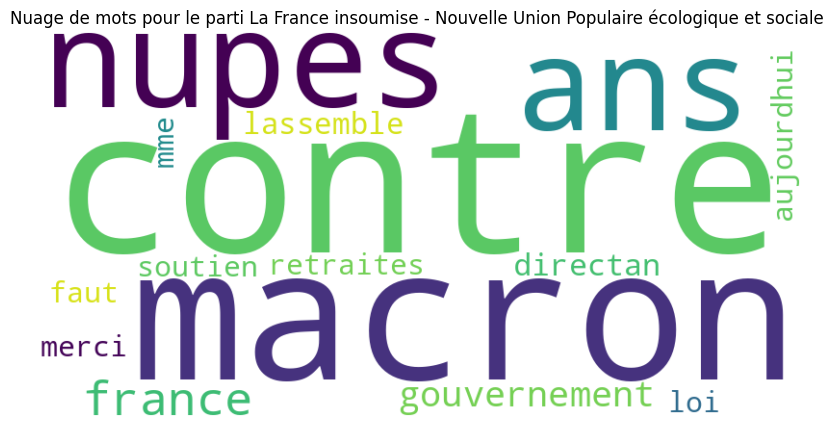

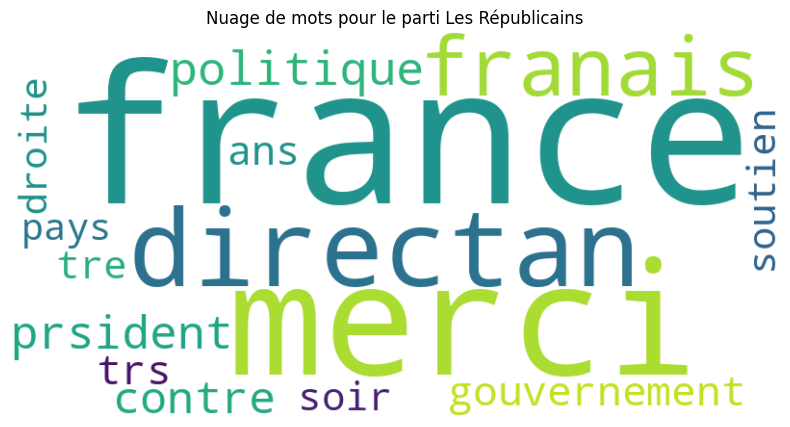

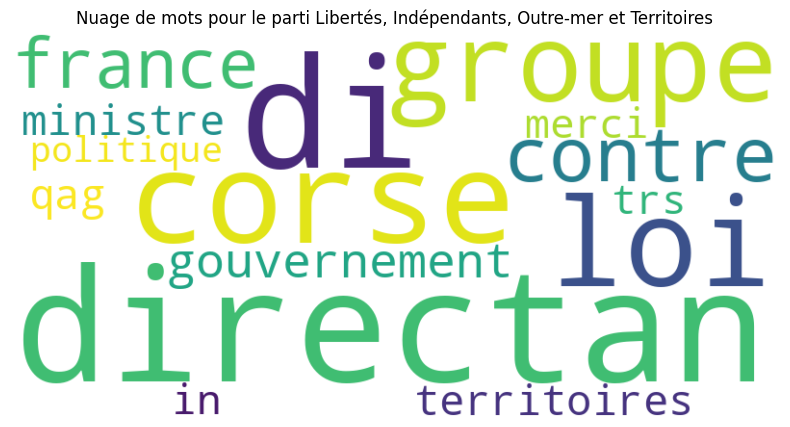

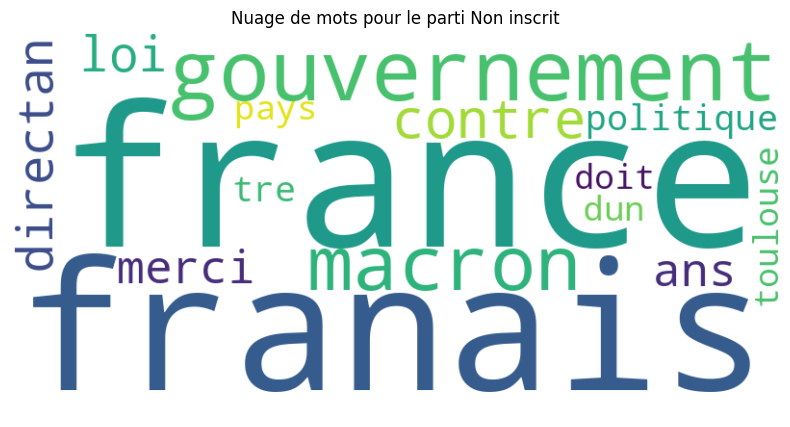

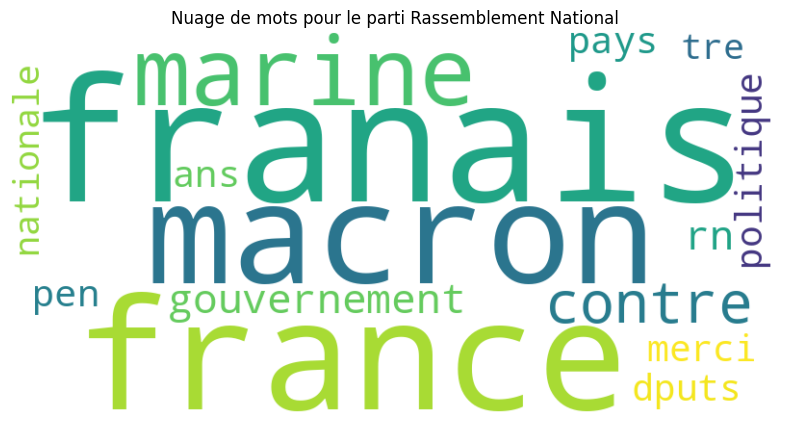

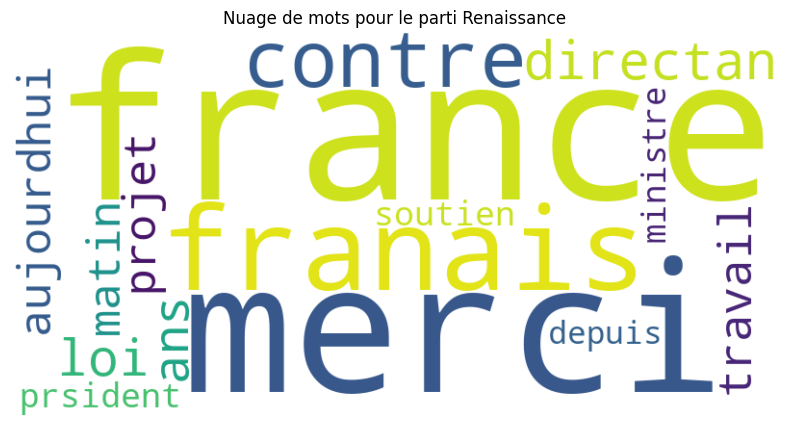

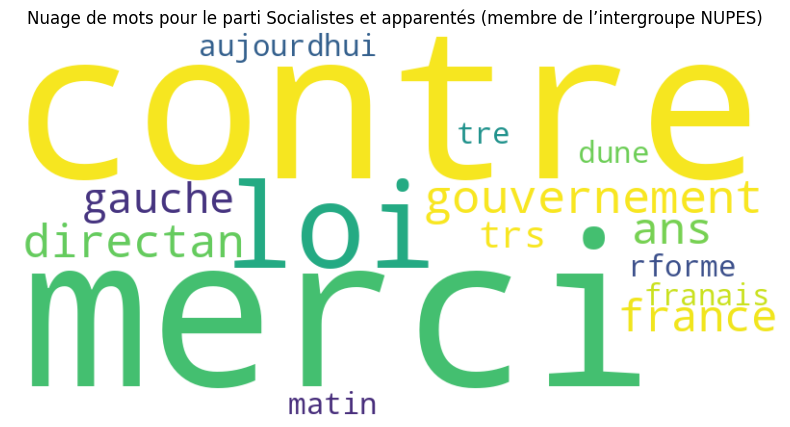

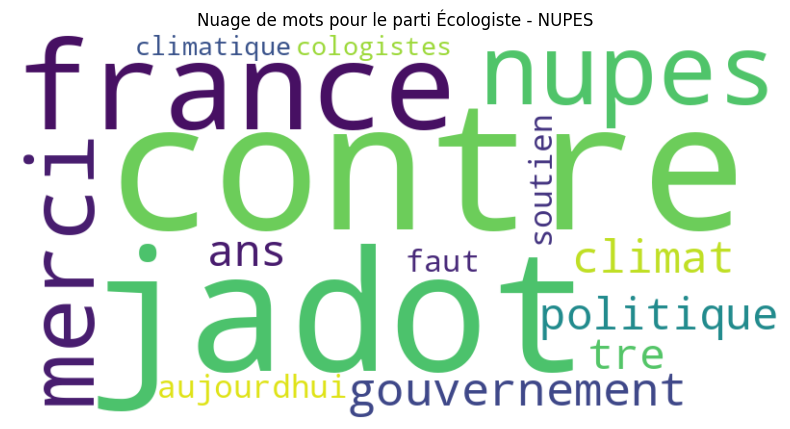

In [9]:
for party, words in party_lexical_counts.items():
    print(f"\nTop mots pour le parti {party}:")
    column_width = 15
    for word, count in words:
        print(f"{word:<{column_width}} {count:<{column_width}}")

for party, words in party_lexical_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuage de mots pour le parti {party}')
    plt.show()